# kaggle房价预测

## 访问数据

In [1]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
train_data=pd.read_csv('./data/house-prices-advanced-regression-techniques/train.csv')
test_data=pd.read_csv('./data/house-prices-advanced-regression-techniques/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
print(train_data.head(n=20))

    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0    1          60       RL         65.0     8450   Pave   NaN      Reg   
1    2          20       RL         80.0     9600   Pave   NaN      Reg   
2    3          60       RL         68.0    11250   Pave   NaN      IR1   
3    4          70       RL         60.0     9550   Pave   NaN      IR1   
4    5          60       RL         84.0    14260   Pave   NaN      IR1   
5    6          50       RL         85.0    14115   Pave   NaN      IR1   
6    7          20       RL         75.0    10084   Pave   NaN      Reg   
7    8          60       RL          NaN    10382   Pave   NaN      IR1   
8    9          50       RM         51.0     6120   Pave   NaN      Reg   
9   10         190       RL         50.0     7420   Pave   NaN      Reg   
10  11          20       RL         70.0    11200   Pave   NaN      Reg   
11  12          60       RL         85.0    11924   Pave   NaN      IR1   
12  13          20       

## 数据预处理

In [4]:
#删除第一列信息，因为对房价无影响
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)

(2919, 79)


In [5]:
#处理非object数据，非str类型数据
#处理丢失值的信息,并进行归一化处理是mean=0,std=0
num_features=all_features.dtypes[all_features.dtypes != 'object'].index
# print(num_features)
# print(all_features[num_features].head(n=20))
all_features[num_features]=all_features[num_features].apply(lambda x: (x-x.mean())/(x.std()))
all_features[num_features]=all_features[num_features].fillna(0)
# all_features.head(n=20),all_features.shape
all_features.shape

(2919, 79)

In [6]:
#处理str类型数据，采用独热编码
all_features=pd.get_dummies(all_features,dummy_na=True)
# all_features.head(n=20),all_features.shape
all_features.shape

(2919, 331)

In [7]:
#将数据转为张量格式
n_train=train_data.shape[0]
print(n_train)
print(train_data.shape[1])

train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1)[:n_train],dtype=torch.float32)
# test_label=torch.tensor(train_data.SalePrice.values.reshape(-1,1)[n_train:n_train+460],dtype=torch.float32)
print(train_features.size())
print(test_features.size())
print(train_labels.size())

1460
81
torch.Size([1460, 331])
torch.Size([1459, 331])
torch.Size([1460, 1])


In [8]:
# train_features=torch.concat((train_features,train_labels),dim=1)
# train_features=torch.concat((train_feature,train_label),dim=1)
# test_features=torch.concat((test_feature,test_labels),dim=1)
batch_size=64
train_loader=DataLoader(train_features,shuffle=False,batch_size=batch_size)
test_loader=DataLoader(test_features,shuffle=False,batch_size=batch_size)
# train_loader_labels=DataLoader(train_labels[:n_train],shuffle=False,batch_size=batch_size)
# test_loader_labels=DataLoader(train_labels[n_train:n_train+460],shuffle=False,batch_size=batch_size)
# train_loader,test_loader

## 建立模型并进行训练

In [9]:
#1.采用多层感知机进行训练
in_features=train_features.shape[1]
def net(in_features):
    net=nn.Sequential(nn.Linear(in_features,256)
                      ,nn.ReLU(),
                      nn.Linear(256,64)
                      ,nn.ReLU(),
#                       nn.Linear(128,64)
#                       ,nn.ReLU(),
                      nn.Linear(64,16)
                      ,nn.ReLU(),
                      nn.Linear(16,4)
                      ,nn.ReLU(),
                      nn.Linear(4,1)
                      ,nn.ReLU())
    return net

## 设置评价指标函数

In [18]:
device=torch.device('cuda:0')
MLP=net(in_features)
MLP.to(device)

Sequential(
  (0): Linear(in_features=331, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=1, bias=True)
  (9): ReLU()
)

In [19]:
#损失优化
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(MLP.parameters(),lr=0.3)
def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse=torch.sqrt(criterion(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

## 模型训练

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs,batch_size):
    train_ls, test_ls = [], []
    train_features,train_labels=train_features.to(device),train_labels.to(device)   
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
#     optimizer = torch.optim.Adam(net.parameters(),
#                                  lr = learning_rate)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = criterion(MLP(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_features,test_labels=test_features.to(device),test_labels.to(device)
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [20]:
#进行训练
def train_s(train_feature,train_label,test_featru,test_labe,num_epochs):
    train_ls=[]
    test_ls=[]
    for epoch in range(num_epochs):
        train_feature,train_label=train_feature.to(device),train_label.to(device)
        for batch_idx,data in enumerate(train_loader,0):
            train_data,train_labels = data[:,:-1],data[:,-1:]
            train_data,train_labels=train_data.to(device),train_labels.to(device)
            optimizer.zero_grad()
            y_pred=MLP(train_data)
            loss=criterion(y_pred,train_labels)
            loss.backward()
            optimizer.step()
        train_ls.append(log_rmse(MLP,train_feature,train_label))
        if test_label is not None:
            test_featur,test_labe=test_featur.to(device),test_labe.to(device)
#             with torch.no_grad():
#                 for data in test_loader:
#                 test_data,test_labels=data[:,:-1],data[:,-1:]
#                 test_data,test_labels=test_data.to(device),test_labels.to(device)
            test_ls.append(log_rmse(MLP,test_feature,test_label))
#     print(len(train_ls))
    return train_ls,test_ls
            
# def test(num_epochs,test_feature,test_label):
#     test_ls=[]
#     for epoch in range(num_epochs):
#         test_feature,test_label=test_feature.to(device),test_label.to(device)
#         with torch.no_grad():
#             for data in test_loader:
#                 test_data,test_labels=data[:,:-1],data[:,-1:]
#                 test_data,test_labels=test_data.to(device),test_labels.to(device)
#             test_ls.append(log_rmse(MLP,test_feature,test_label))
#     return test_ls

## K折交叉验证

In [15]:
#获得第k折数据
def get_k_flod_data(k,i,X,y):
    assert k > 1
    flod_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*flod_size,(j+1)*flod_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_vaild,y_vaild=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            X_train=torch.concat((X_train,X_part),dim=0)
            y_train=torch.concat((y_train,y_part),dim=0)
    return X_train,y_train,X_vaild,y_vaild

In [22]:
#k折交叉验证
def k_flod(k,X_train,y_train,num_epochs,batch_size):
    train_l_sum,vaild_l_sum=0,0
    for i in range(k):
        X_train,y_train,X_vaild,y_vaild=get_k_flod_data(k,i,X_train,y_train)
        train_ls,vaild_ls=train_s(MLP,X_train,y_train,X_vaild,y_vaild,num_epochs,batch_size)
        train_l_sum += train_ls[-1]
        vaild_l_sum += vaild_ls[-1]
        # if i==0:
            #  d2l.plot(list(range(1, num_epochs + 1)), [train_ls, vaild_ls],
            #          xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
            #          legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(vaild_ls[-1]):f}')
    return train_l_sum/k, vaild_l_sum/k

In [23]:
k=5
batch_size=64
train_l,vaild_l = k_flod(k,train_features,train_labels,num_epochs=300,batch_size=batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(vaild_l):f}')

TypeError: train_s() takes 5 positional arguments but 7 were given

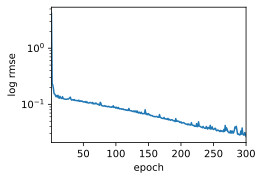

In [466]:
epoch=300
test_labels=None
train_ls,_=train(MLP,train_features=train_features,train_labels=train_labels,test_features=test_features,
               test_labels=test_labels,num_epochs=epoch,batch_size=64)
plt.plot(np.arange(1, epoch + 1), np.array(train_ls).reshape(epoch,1))
plt.xlabel('epoch')
plt.ylabel('log rmse')
plt.xlim([1,epoch])
plt.yscale('log')
plt.show()

6
